In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer, f1_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.cm as cm
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
#%matplotlib notebook
#plt.style.use('ggplot')

In [3]:
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

In [4]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]

#new df with dropped nans, inplace=True
pitches.drop(index=rows_with_nans, axis=0, inplace=True)
pitches.reset_index(inplace=True)
#finds 'UN' in pitches and drops those rows
UN_mask = np.where(pitches['pitch_type'] == 'UN')[0]
#drops the rows using the indicies from above
pitches.drop(UN_mask, inplace=True)
#gets rid of po because it is the same as fo
pitches['pitch_type'].replace('PO', 'FO', inplace=True)

In [6]:
atbats = pd.read_csv('../data/atbats.csv', low_memory=False)

games = pd.read_csv('../data/games.csv', low_memory=False)

names = pd.read_csv('../data/player_names.csv', low_memory=False)

In [7]:
#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'code', 'type', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'ab_id']], on='ab_id')

#creates full name column inside names df
names['full_name'] = names['first_name'] + ' ' + names['last_name']
#merges names with game situation df 
merged_names = pd.merge(names[['full_name', 'id']], game_sit, left_on='id', right_on='batter_id')
#merges the above merged names with the pitcher id now
final_play_df = pd.merge(merged_names, names[['full_name', 'id']], left_on='pitcher_id', right_on='id')
#renames some of the merged column names, and drops other id_x and id+y columns
final_play_df = final_play_df.rename(columns={'full_name_x':'batter_name', 'g_id':'game_id', 'o' :'post_outs', 'stand':'batter_stand', 'full_name_y':'pitcher_name'}).drop(columns=['id_x', 'id_y'])

In [8]:
#grabs columns that make sense
final_play_df = final_play_df[['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id', 'inning', 'p_score', 'p_throws', 'batter_stand', 'top', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'pitch_type']]
#replaces R and L with 1's and 0's
final_play_df.replace({'R': 1, 'L': 0}, inplace=True)

## Future Directions

Using each at bat to predict the outcome of the at bat? Using LSTM to know what the count is (how many balls and strikes), to use how many pitches the pitcher has thrown, to use what pitch types he has thrown, to use the handedness of the batter and pitcher, using the score of the game.. So on...

Or using Linear Regression to see how many pitches the pitcher can withstand? Using some sort of metric about the number of hits/runs they give up to know how many pitches thrown is too many. 

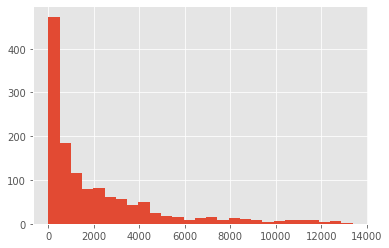

In [9]:
#how many pitches has each pitcher thrown? 
final_play_df.groupby('pitcher_name').count().sort_values('batter_name', ascending=False).iloc[:, 0].hist(bins='fd')

In [10]:
final_play_df

,pitcher_name,batter_name,ab_id,batter_id,pitcher_id,game_id,inning,p_score,p_throws,batter_stand,top,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitch_type
0,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,FC
1,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,FC
2,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,2.0,2.0,3.0,0.0,0.0,1.0,FF
3,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,FC
4,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,CU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847188,Rob Brantly,Bradley Zimmer,2017160269,605548,542963,201702093,9,2,1,0,True,10.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,CU
2847189,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,CU
2847190,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,CU
2847191,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,CU


In [11]:
pitchers_top500 = final_play_df.groupby('pitcher_name').count().sort_values('batter_name', ascending=False).iloc[:500, 0].index
pitchers_top500

Index(['Max Scherzer', 'Justin Verlander', 'Chris Archer', 'Jose Quintana',
       'Rick Porcello', 'Chris Sale', 'Jon Lester', 'Corey Kluber',
       'Gio Gonzalez', 'Zack Greinke',
       ...
       'Jason Motte', 'Juan Minaya', 'Frankie Montas', 'Kevin McCarthy',
       'Julio Urias', 'Brett Oberholtzer', 'James Pazos', 'Dereck Rodriguez',
       'Warwick Saupold', 'Drew Steckenrider'],
      dtype='object', name='pitcher_name', length=500)

In [12]:
df_500 = final_play_df[final_play_df['pitcher_name'].isin(pitchers_top500)]

Text(0.5, 0, 'Pitch Types')

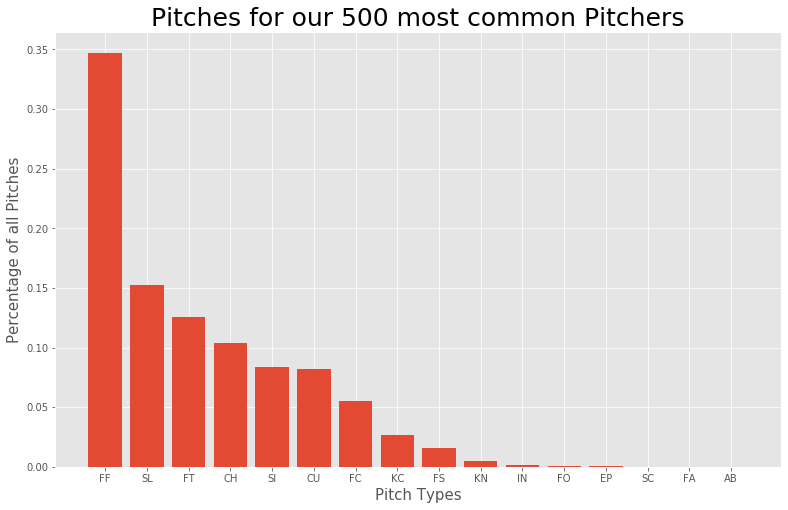

In [14]:
values = df_500.groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0].values
index = df_500.groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0].index
plt.figure(figsize=(13, 8))
plt.bar(index, values/np.sum(values))
plt.title('Pitches for our 500 most common Pitchers', size=25)
plt.ylabel('Percentage of all Pitches', size=15)
plt.xlabel('Pitch Types', size=15)

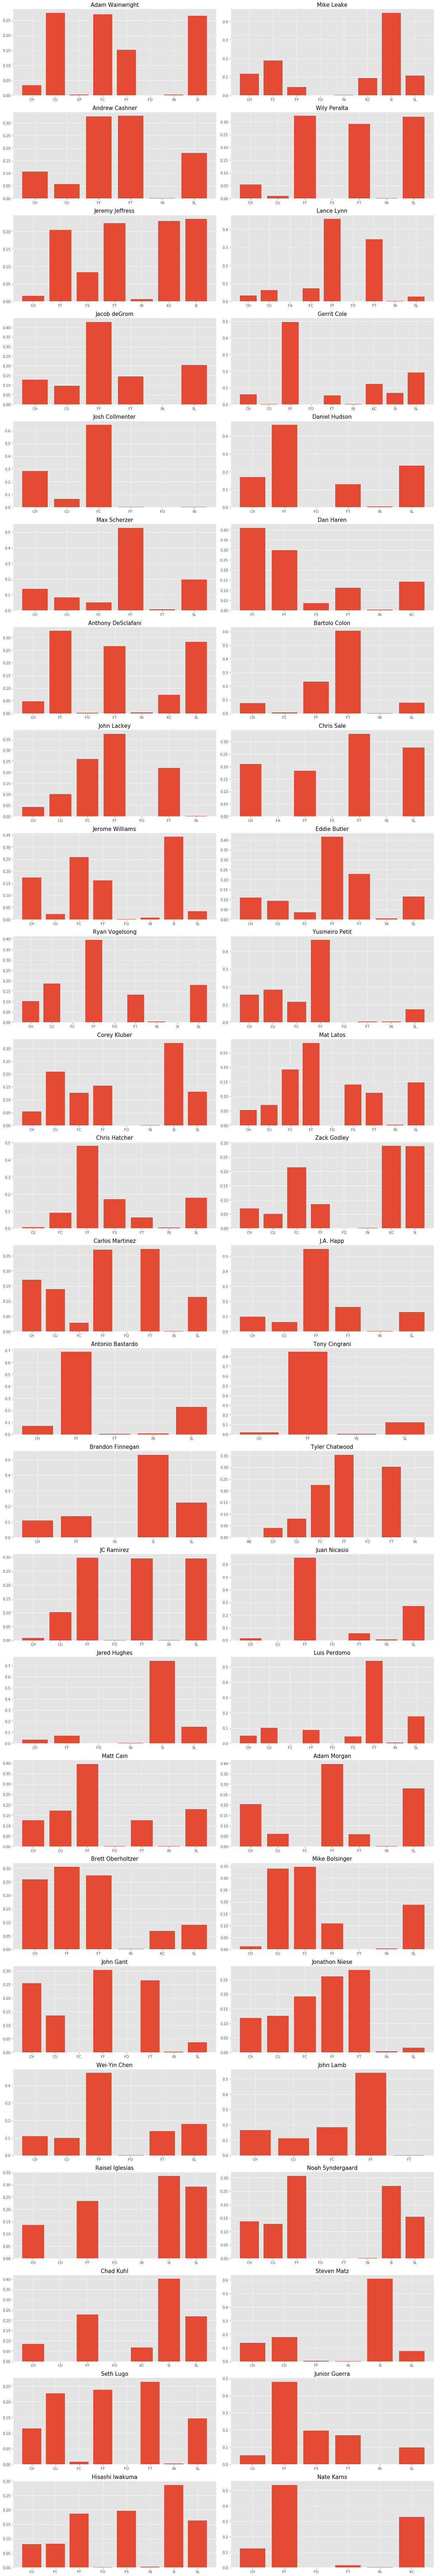

In [15]:
num_pitchers = 50

fig, axs = plt.subplots(num_pitchers // 2, 2, figsize=(17, num_pitchers * 2))

for name, ax in zip(df_500['pitcher_name'].unique()[:num_pitchers], axs.flatten()):
    vals = df_500[df_500['pitcher_name'] == name].groupby('pitch_type').count().sort_values('pitch_type').iloc[:, 0].values
    index = df_500[df_500['pitcher_name'] == name].groupby('pitch_type').count().sort_values('pitch_type').iloc[:, 0].index
    ax.bar(index, vals / np.sum(vals))
    ax.set_title(name, size=15)
plt.tight_layout()

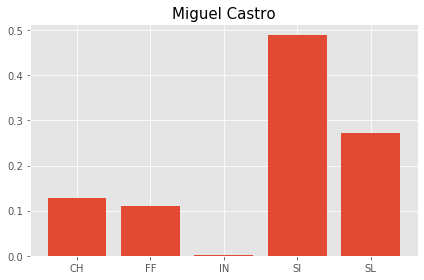

In [17]:
vals = df_500[df_500['pitcher_name'] == 'Miguel Castro'].groupby('pitch_type').count().sort_values('pitch_type').iloc[:, 0].values
index = df_500[df_500['pitcher_name'] == 'Miguel Castro'].groupby('pitch_type').count().sort_values('pitch_type').iloc[:, 0].index
plt.bar(index, vals / np.sum(vals))
plt.title('Miguel Castro', size=15)
plt.tight_layout()

In [37]:
def model_each_pitcher(estimator, num_pitchers:int=5, binary:bool=True, randomseed=True):
    if randomseed:
        random.seed(2527)
    
    #lst_pitchers = random.choices(final_play_df['pitcher_name'], k=num_pitchers)
    lst_pitchers = df_500['pitcher_name'].unique()[:num_pitchers]
    cross_val_scores = {}
    for pitcher in lst_pitchers:
        df_pitcher = df_500[df_500['pitcher_name'] == pitcher]
        df = pd.merge(df_pitcher, pd.get_dummies(df_500['batter_name']),left_index=True, right_index=True).drop(columns=['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id'])
        thresh = round(df.shape[0] * 0.75)
        Xtrain = df.drop(columns='pitch_type').iloc[:thresh, :]
        if binary == False:
            ytrain = df['pitch_type'][:thresh].values
        else:
            #this line groups by pitch and sorts it and grabs the most common pitch type to use as a target if predicting with 2 classes
            most_common_pitch = df.groupby('pitch_type').count().sort_values('inning', ascending=False).iloc[:, 0].index[0]   
            ytrain = np.where(df['pitch_type'][:thresh] == most_common_pitch, 1, 0)
        cross_val_scores[pitcher] = [cross_val(estimator, Xtrain.values, ytrain), df.shape[0]]
    return cross_val_scores
    


def cross_val(estimator, X, y):
    '''
    estimator = The model you want to use with the sepcified paramters
                        ex: LogisticRegression(), RandomForestClassification() ...
                        
    data = clean dataframe you are working with, no nans
    
    clean_features = list of features you want to observe in your model
    
    target = target column you want to predict against
    '''

    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    acc_scores = []
    f1_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        #y_test_pred = model.predict(X_test)
        acc_scores.append(model.score(X_test, y_test))
        
        #change micro to weighted?
        #f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='micro'))
    
    #if binary:
       # return np.mean(acc_scores)
    #print('F1 Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(f1_scores)))
    #print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return np.mean(acc_scores)

In [238]:
#multiclass logistic regression accuracy scores
model_each_pitcher(LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial'), binary=False)

{'Miguel Castro': [0.5507453977886047, 3022],
 'Josh Osich': [0.40664451827242526, 2007],
 'Derek Holland': [0.5023064250411862, 8094],
 'Xavier Cedeno': [0.6126134870083915, 2096],
 'James Shields': [0.35630315205617313, 11784]}

In [237]:
#lets try out of the box random forest classifier to see how it does
model_each_pitcher(RandomForestClassifier(), binary=False)

{'Miguel Castro': [0.5414767920179712, 3022],
 'Josh Osich': [0.44451827242524916, 2007],
 'Derek Holland': [0.45008237232289944, 8094],
 'Xavier Cedeno': [0.5667637245981194, 2096],
 'James Shields': [0.3587911996455889, 11784]}

In [250]:
#parameter space for randomized grid search
#using random forest classifier
n_estimators = [50, 100, 200]
max_features = ['log2', 'sqrt', None]
max_depth = [2, 3, 6]
min_samples_split = [2, 4, 8]
min_samples_leaf = [1, 2, 4]
learning_rate  = [0.1, 0.05, 0.025]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
scorer = 'accuracy'
# create 20 gbc objects to be tuned and fitted
rf1 = RandomForestClassifier()
clf = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 10, scoring=scorer, n_jobs = -1, cv = 5, verbose=0)

In [251]:
clf.fit(X_mtrain, y_mtrain)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [252]:
clf.best_params_

{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 6}

In [255]:
#randomized grid search parameters for randomforest classifier 
model_each_pitcher(RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_depth=6), binary=False)

{'Miguel Castro': [0.4585183456350711, 3022],
 'Josh Osich': [0.3554817275747509, 2007],
 'Derek Holland': [0.5212520593080724, 8094],
 'Xavier Cedeno': [0.4706986149024365, 2096],
 'James Shields': [0.2637490493128164, 11784]}

In [263]:
#tried gradient boosting
model_each_pitcher(GradientBoostingClassifier(), binary=False)

{'Miguel Castro': [0.5578084429792571, 3022],
 'Josh Osich': [0.41262458471760793, 2007],
 'Derek Holland': [0.5080724876441516, 8094],
 'Xavier Cedeno': [0.5903204933778182, 2096],
 'James Shields': [0.39714877070065324, 11784]}

In [21]:
#tried decision tree classifiers which is fastest
model_each_pitcher(DecisionTreeClassifier(), binary = False)

{'Miguel Castro': [0.49733737880600204, 3022],
 'Josh Osich': [0.3893687707641196, 2007],
 'Derek Holland': [0.39769357495881386, 8094],
 'Xavier Cedeno': [0.5388211505408957, 2096],
 'James Shields': [0.32812952136581425, 11784]}

In [112]:
#run decision tree classifier model on first 100 pitchers out of 500, print time
start = time.time()
dict_scores_all = model_each_pitcher(DecisionTreeClassifier(), num_pitchers=500, binary=False)
print(time.time() - start)

2419.850068092346


In [114]:
#pitcher name and accuracy score, and number of pitches
dict_scores_all

{'Adam Wainwright': [0.28718608867291007, 6434],
 'Mike Leake': [0.34931241536332386, 10932],
 'Andrew Cashner': [0.3416478088237783, 10748],
 'Wily Peralta': [0.37916341090538475, 5606],
 'Jeremy Jeffress': [0.3644578783151326, 4270],
 'Lance Lynn': [0.44621327072252664, 9135],
 'Jacob deGrom': [0.3370193647730706, 11699],
 'Gerrit Cole': [0.39555808656036445, 11707],
 'Josh Collmenter': [0.5455799332820119, 2881],
 'Daniel Hudson': [0.41642036124794746, 4060],
 'Max Scherzer': [0.4284005979073243, 13380],
 'Dan Haren': [0.35383317515554147, 2905],
 'Anthony DeSclafani': [0.3331995987963892, 6647],
 'Bartolo Colon': [0.5256401546570466, 10063],
 'John Lackey': [0.37262828197353265, 8698],
 'Chris Sale': [0.38003500758984304, 12582],
 'Jerome Williams': [0.32258082343188726, 2194],
 'Eddie Butler': [0.35051846526181485, 4188],
 'Ryan Vogelsong': [0.32743682310469313, 3697],
 'Yusmeiro Petit': [0.41144475920679885, 4705],
 'Corey Kluber': [0.26758483695698776, 12472],
 'Mat Latos': [0.2

In [38]:
#creates a dataframe from dictionary

keys = []
vals = []
num_pitches = []
for key,value in dict_scores.items():   #loops through keys and values
    keys.append(key)
    vals.append(value[0])
    num_pitches.append(value[1])

    
df_100_acc = pd.DataFrame(index=keys)     #creates df and populates using lists from loop
df_100_acc['accuracy'] = vals
df_100_acc['num_pitches'] = num_pitches

In [115]:
#creates a dataframe from dictionary

keys = []
vals = []
num_pitches = []
for key,value in dict_scores_all.items():   #loops through keys and values
    keys.append(key)
    vals.append(value[0])
    num_pitches.append(value[1])

    
df_all_acc = pd.DataFrame(index=keys)     #creates df and populates using lists from loop
df_all_acc['accuracy'] = vals
df_all_acc['num_pitches'] = num_pitches

In [117]:
df_all_acc.to_csv('../Models/dt_pitcher_accuracy.csv')

In [211]:
df_all_acc.sort_values('accuracy', ascending=False)

,name,level_0,name,accuracy,num_pitches,batting_avg_agnst
499,499,499,Zach Britton,0.836829,3179,0.166606
498,498,498,Sean Doolittle,0.789941,2253,0.268188
497,497,497,R.A. Dickey,0.782575,8861,0.227586
496,496,496,Tony Cingrani,0.768692,2853,0.239854
495,495,495,Bryan Shaw,0.738602,4387,0.253497
...,...,...,...,...,...,...
4,4,4,Johnny Cueto,0.258357,9769,0.214827
3,3,3,Masahiro Tanaka,0.253804,10428,0.282121
2,2,2,Hisashi Iwakuma,0.250882,5294,0.244931
1,1,1,Clay Buchholz,0.242903,5495,0.243883


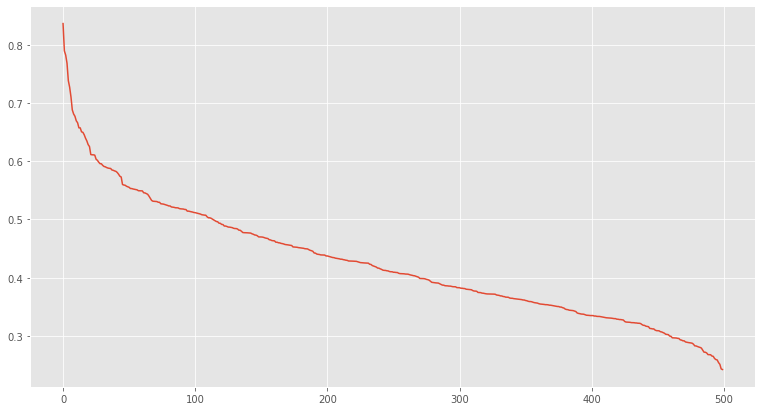

In [123]:
plt.figure(figsize=(13, 7))
plt.plot(np.arange(500), df_all_acc.sort_values('accuracy', ascending=False)['accuracy'].values)
plt.xlabel('Pitchers', size=15)
plt.ylabel('CV Accuracy Score', size=15)
plt.title('CV Accuracy scores of all pitchers')

In [124]:
#using code from earlier to grab the 'event' from atbats to find batting average against

#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'code', 'type', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'ab_id']], on='ab_id')

#creates full name column inside names df
names['full_name'] = names['first_name'] + ' ' + names['last_name']
#merges names with game situation df 
merged_names = pd.merge(names[['full_name', 'id']], game_sit, left_on='id', right_on='batter_id')
#merges the above merged names with the pitcher id now
final_play_df = pd.merge(merged_names, names[['full_name', 'id']], left_on='pitcher_id', right_on='id')
#renames some of the merged column names, and drops other id_x and id+y columns
final_events = final_play_df.rename(columns={'full_name_x':'batter_name', 'g_id':'game_id', 'o' :'post_outs', 'stand':'batter_stand', 'full_name_y':'pitcher_name'}).drop(columns=['id_x', 'id_y'])

In [125]:
#grabs all 500 top pitchers
df_500_events = final_events[final_events['pitcher_name'].isin(pitchers_top500)]

In [126]:
#this cell takes each pitcher name and calculates a baa 

lst_baa = []
for name in df_all_acc.index:
    events = df_500_events[df_500_events['pitcher_name'] == name].groupby('event').count().iloc[:, 0]
    hits = 0
    denom = np.sum(events)
    if 'Intent Walk' in events.index:
        denom -= events['Intent Walk']
    if 'Walk' in events.index:
        denom -= events['Walk']
    if 'Sac Bunt' in events.index:
        denom -= events['Sac Bunt']
    if 'Sac Fly' in events.index:
        denom -= events['Sac Fly']
    if 'Hit By Pitch' in events.index:
        denom -= events['Hit By Pitch']
    if 'Single' in events.index:
        hits += events['Single']
    if 'Double' in events.index:
        hits += events['Double']
    if 'Home Run' in events.index:
        hits += events['Home Run']
    if 'Triple' in events.index:
        hits += events['Triple']
    lst_baa.append(hits/denom)

In [206]:
df_all_acc['batting_avg_agnst'] = lst_baa   #puts baa into df 

In [207]:
#lets sort it so we can find any trends between accuracy and baa
df_all_acc.sort_values('accuracy', inplace=True)

In [208]:
df_all_acc.reset_index(inplace=True)

In [216]:
df_all_acc.rename(columns={'index':'name'}, inplace=True)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [217]:
df_all_acc

,name,name,accuracy,num_pitches,batting_avg_agnst
0,0,Jeremy Guthrie,0.241936,2524,0.253246
1,1,Clay Buchholz,0.242903,5495,0.243883
2,2,Hisashi Iwakuma,0.250882,5294,0.244931
3,3,Masahiro Tanaka,0.253804,10428,0.282121
4,4,Johnny Cueto,0.258357,9769,0.214827
...,...,...,...,...,...
495,495,Bryan Shaw,0.738602,4387,0.253497
496,496,Tony Cingrani,0.768692,2853,0.239854
497,497,R.A. Dickey,0.782575,8861,0.227586
498,498,Sean Doolittle,0.789941,2253,0.268188


In [218]:
df_all_acc.columns = ['index_0', 'name', 'accuracy', 'num_pitches', 'batting_avg_agnst']

In [219]:
df_all_acc

,index_0,name,accuracy,num_pitches,batting_avg_agnst
0,0,Jeremy Guthrie,0.241936,2524,0.253246
1,1,Clay Buchholz,0.242903,5495,0.243883
2,2,Hisashi Iwakuma,0.250882,5294,0.244931
3,3,Masahiro Tanaka,0.253804,10428,0.282121
4,4,Johnny Cueto,0.258357,9769,0.214827
...,...,...,...,...,...
495,495,Bryan Shaw,0.738602,4387,0.253497
496,496,Tony Cingrani,0.768692,2853,0.239854
497,497,R.A. Dickey,0.782575,8861,0.227586
498,498,Sean Doolittle,0.789941,2253,0.268188


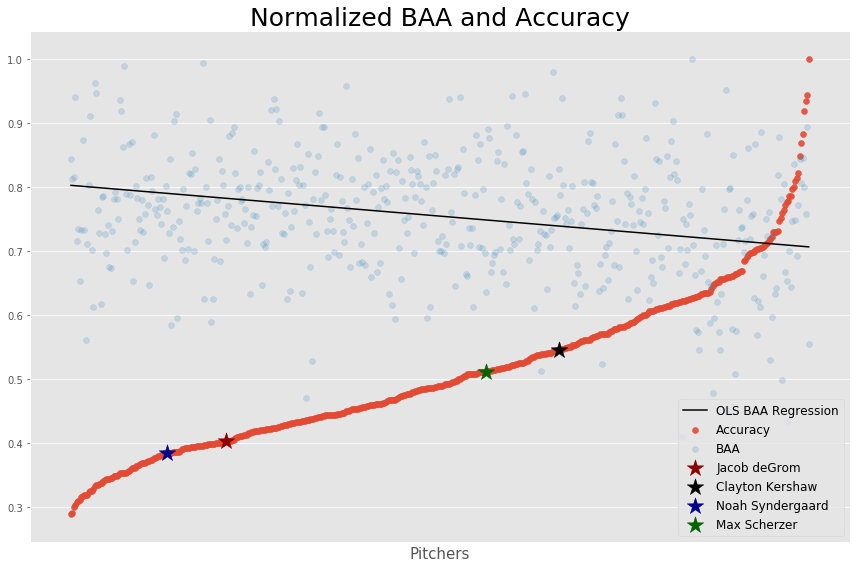

In [241]:
#lets plot it to see 
plt.figure(figsize=(12,8))
plt.scatter(df_all_acc.index, df_all_acc['accuracy']/np.max(df_all_acc['accuracy']), alpha=0.9, label='Accuracy')
plt.xticks([])
plt.scatter(df_all_acc.index, df_all_acc['batting_avg_agnst']/np.max(df_all_acc['batting_avg_agnst']), alpha=0.2, label='BAA')
plt.plot(sm_results.params[0] + x * sm_results.params[1], c='k', label='OLS BAA Regression')

plt.scatter(df_all_acc[df_all_acc['name'] == 'Jacob deGrom'].index, df_all_acc[df_all_acc['name'] == 'Jacob deGrom']['accuracy']/np.max(df_all_acc['accuracy']), marker= '*', c='darkred', s=300, label='Jacob deGrom')
plt.scatter(df_all_acc[df_all_acc['name'] == 'Clayton Kershaw'].index, df_all_acc[df_all_acc['name'] == 'Clayton Kershaw']['accuracy']/np.max(df_all_acc['accuracy']), marker= '*', c='k', s=300, label='Clayton Kershaw')
plt.scatter(df_all_acc[df_all_acc['name'] == 'Noah Syndergaard'].index, df_all_acc[df_all_acc['name'] == 'Noah Syndergaard']['accuracy']/np.max(df_all_acc['accuracy']), marker='*', c='darkblue', s=300, label='Noah Syndergaard')
plt.scatter(df_all_acc[df_all_acc['name'] == 'Max Scherzer'].index, df_all_acc[df_all_acc['name'] == 'Max Scherzer']['accuracy']/np.max(df_all_acc['accuracy']), marker='*', c='darkgreen', s=300, label='Max Scherzer')

plt.tight_layout()
plt.title('Normalized BAA and Accuracy', size=25)
plt.xlabel('Pitchers', size=15)
plt.legend(fontsize='large', loc='lower right')
plt.tight_layout()
plt.savefig('../Graphics/baa_accuracy_all500.png')

In [243]:
df_all_acc[df_all_acc['name'] == 'Lucas Giolito']

,index_0,name,accuracy,num_pitches,batting_avg_agnst
175,175,Lucas Giolito,0.371669,4104,0.224952


In [140]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [155]:
X = sm.add_constant(np.arange(500))
y = df_all_acc['batting_avg_agnst']/np.max(df_all_acc['batting_avg_agnst'])

In [156]:
simple_linear = OLS(y, X)
sm_results = simple_linear.fit()
sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      batting_avg_agnst   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     46.83
Date:                Fri, 28 Feb 2020   Prob (F-statistic):           2.28e-11
Time:                        11:20:57   Log-Likelihood:                 490.97
No. Observations:                 500   AIC:                            -977.9
Df Residuals:                     498   BIC:                            -969.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8027      0.008     98.963      0.000       0.787       0.819
x1            -0.0002   2.81e-05     -6.843      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        5.043   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.066
Skew:                          -0.182   Prob(JB):                       0.0794
Kurtosis:                       3.333   Cond. No.                         576.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
sm_results.params

const    0.802697
x1      -0.000193
dtype: float64

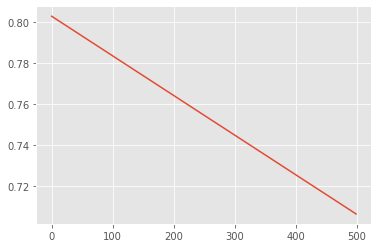

In [159]:
x = np.arange(500)
plt.plot(sm_results.params[0] + x * sm_results.params[1])

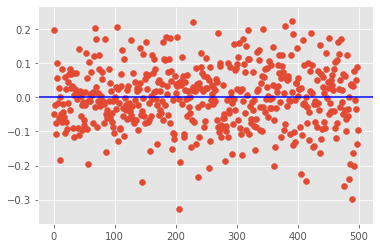

In [174]:
plt.scatter(np.arange(500), sm_results.resid.values)
plt.axhline(0, c='b')

In [170]:
stud_resid = sm_results.outlier_test()['student_resid'].values

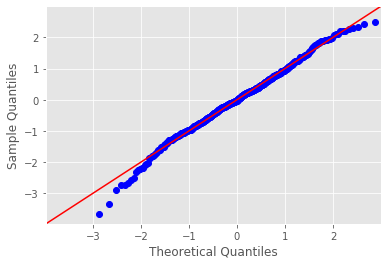

In [172]:
ax = sm.graphics.qqplot(stud_resid, line='45')

## Make vectors of distribution of pitch type for each pitcher

In [311]:
pitchers_vectors = pd.DataFrame(columns=df_500['pitch_type'].unique())

In [312]:
for i, name in enumerate(df_all_acc['name']):
    #print(i, name)
    x = df_500[df_500['pitcher_name'] == name].groupby('pitch_type').count().iloc[:, 0]
    x = x / x.sum()
    pitcher_row = x.to_frame().T
    pitcher_row['name'] = i
    pitchers_vectors = pd.concat((pitchers_vectors, pitcher_row))

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [324]:
final_vectors = pitchers_vectors.merge(df_all_acc[['name', 'index_0']], left_on='name', right_on='index_0')
final_vectors.drop(columns=['name_x', 'index_0'], inplace=True)

final_vectors.fillna(0, inplace=True)

final_vectors.set_index('name_y', inplace=True)

In [334]:
final_vectors

,AB,CH,CU,EP,FA,FC,FF,FO,FS,FT,IN,KC,KN,SC,SI,SL
name_y,,,,,,,,,,,,,,,,
Jeremy Guthrie,0.0,0.162837,0.162837,0.002377,0.000000,0.148970,0.293978,0.000000,0.000000,0.000000,0.001585,0.0,0.000000,0.0,0.172345,0.055071
Clay Buchholz,0.0,0.170883,0.172884,0.000000,0.000000,0.232211,0.195996,0.000000,0.006187,0.221656,0.000182,0.0,0.000000,0.0,0.000000,0.000000
Hisashi Iwakuma,0.0,0.000000,0.081224,0.000000,0.000000,0.081791,0.186815,0.000756,0.196827,0.000000,0.002267,0.0,0.000000,0.0,0.287117,0.163204
Masahiro Tanaka,0.0,0.000000,0.056099,0.000000,0.000000,0.070387,0.151323,0.000096,0.284139,0.000000,0.000000,0.0,0.000000,0.0,0.151323,0.286632
Johnny Cueto,0.0,0.196233,0.003890,0.000000,0.000102,0.144744,0.276384,0.000000,0.000000,0.203706,0.000409,0.0,0.000000,0.0,0.000000,0.174532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bryan Shaw,0.0,0.002279,0.000000,0.000000,0.000000,0.828129,0.003647,0.000228,0.000000,0.000000,0.002507,0.0,0.000000,0.0,0.000000,0.163209
Tony Cingrani,0.0,0.021732,0.000000,0.000000,0.000000,0.000000,0.848580,0.000000,0.000000,0.000000,0.005608,0.0,0.000000,0.0,0.000000,0.124080
R.A. Dickey,0.0,0.000000,0.000000,0.022909,0.000000,0.000000,0.134748,0.000113,0.000000,0.000000,0.000226,0.0,0.842004,0.0,0.000000,0.000000


In [335]:
from sklearn.manifold import TSNE

In [337]:
tsne = TSNE(n_components=2, n_jobs=-1, random_state=2527).fit_transform(final_vectors.values)

Text(0.5, 1.0, 'TSNE Pitch Type Distribution by Pitcher')

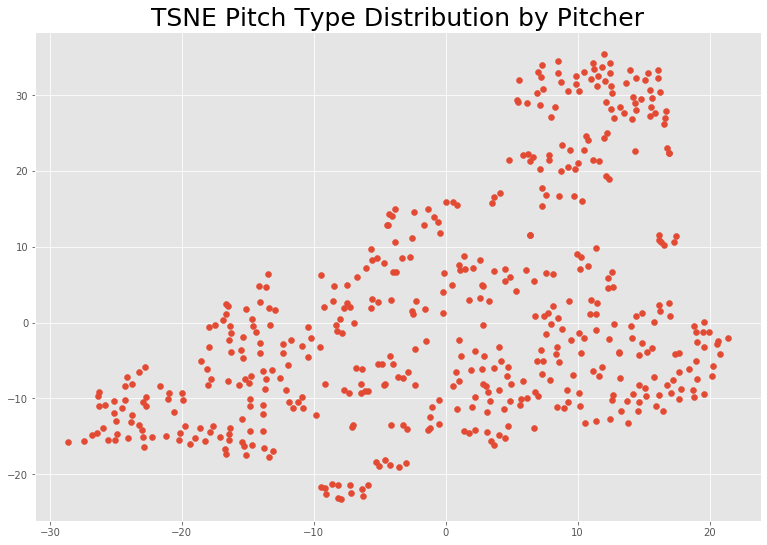

In [345]:
plt.figure(figsize=(13,9))
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.title('TSNE Pitch Type Distribution by Pitcher', size=25)


In [346]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

For n_clusters = 2 The average silhouette_score is : 0.42446914


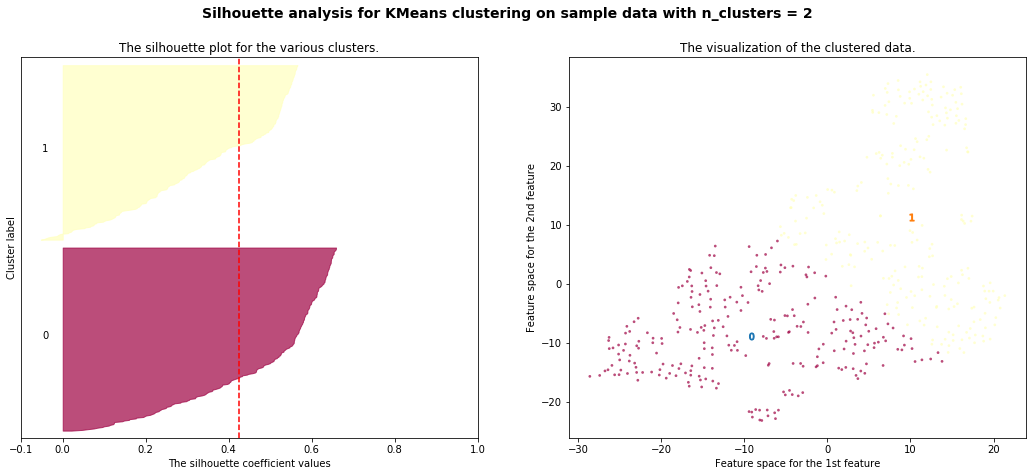

For n_clusters = 3 The average silhouette_score is : 0.48081574


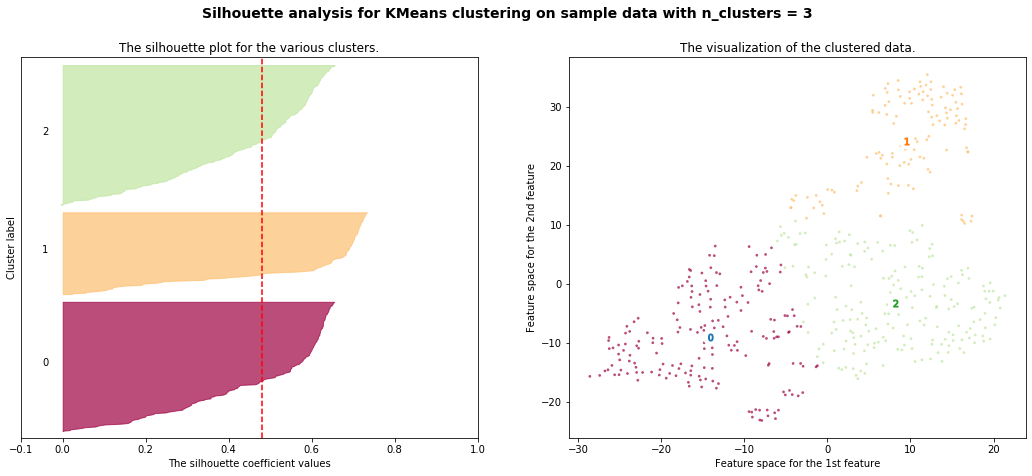

For n_clusters = 4 The average silhouette_score is : 0.46677363


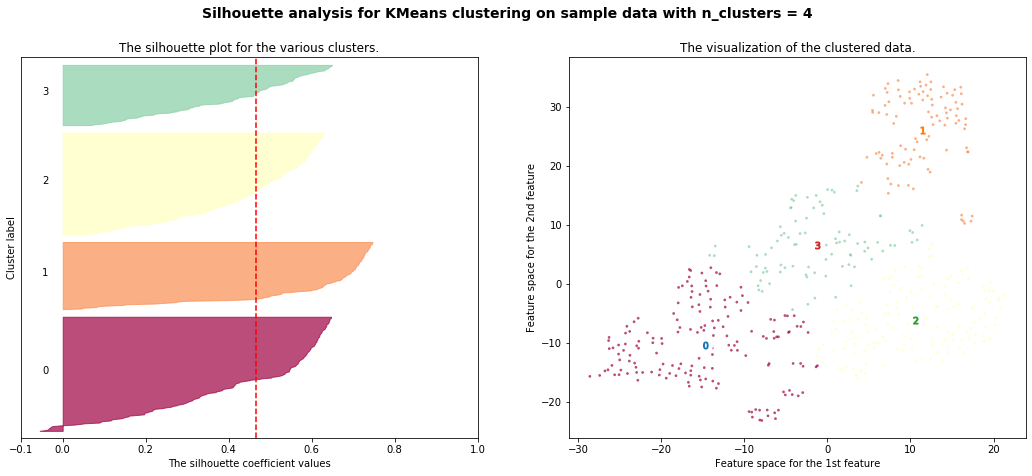

For n_clusters = 5 The average silhouette_score is : 0.46212572


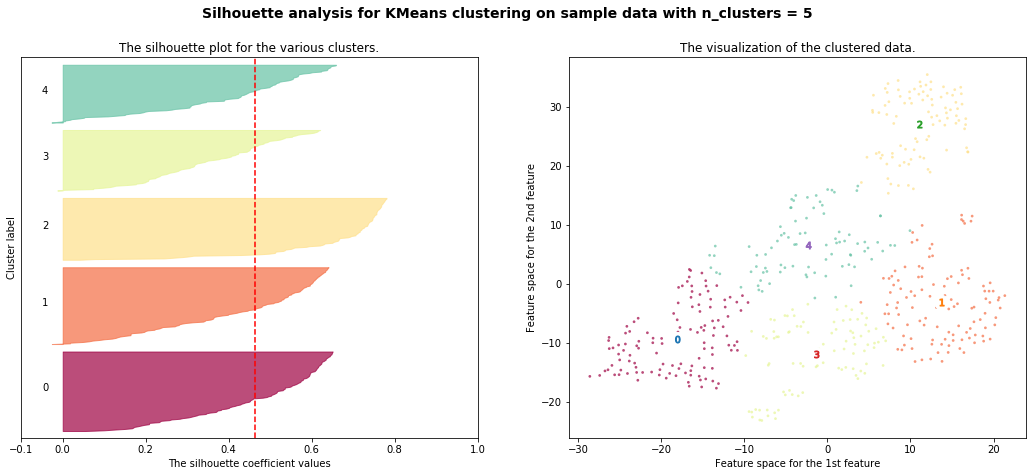

For n_clusters = 6 The average silhouette_score is : 0.44031802


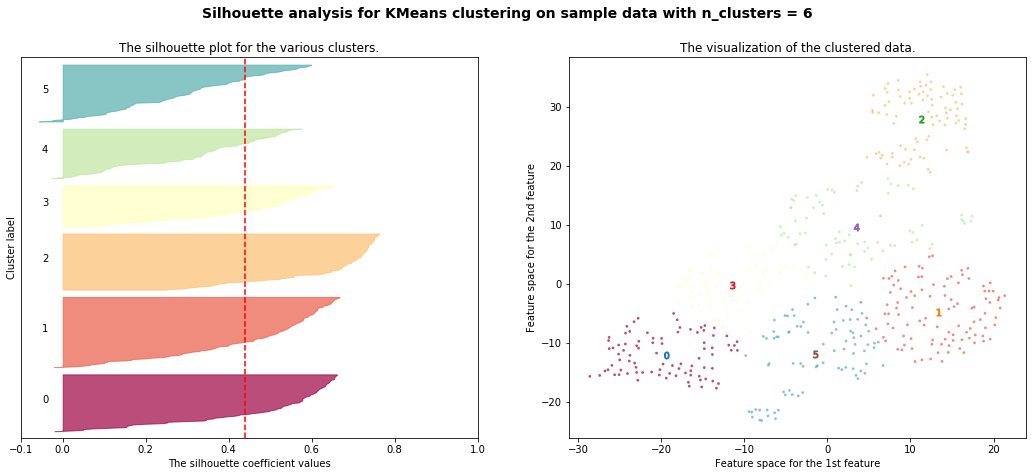

For n_clusters = 7 The average silhouette_score is : 0.42812446


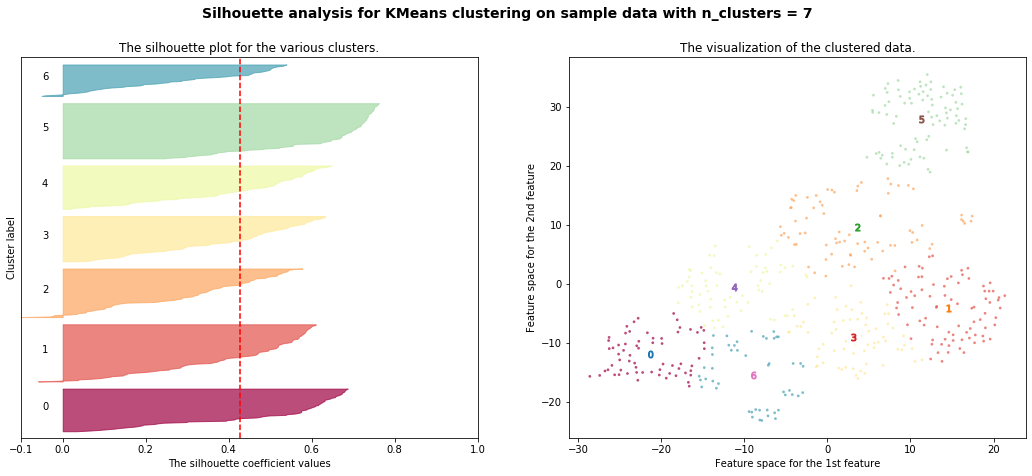

For n_clusters = 8 The average silhouette_score is : 0.43937793


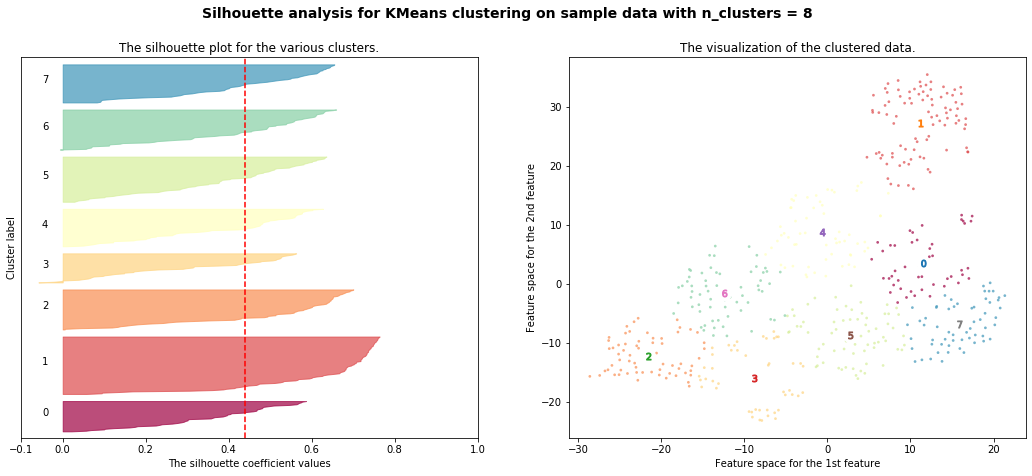

For n_clusters = 9 The average silhouette_score is : 0.41469762


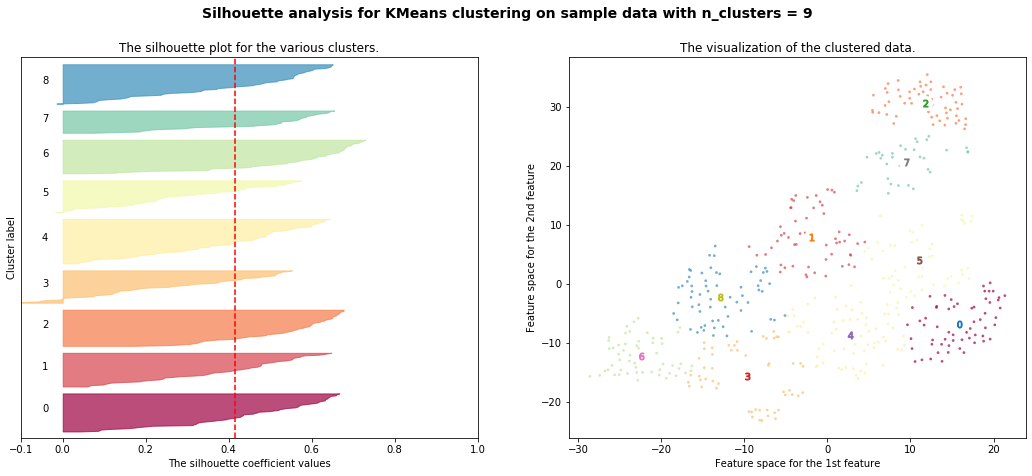

For n_clusters = 10 The average silhouette_score is : 0.42262873


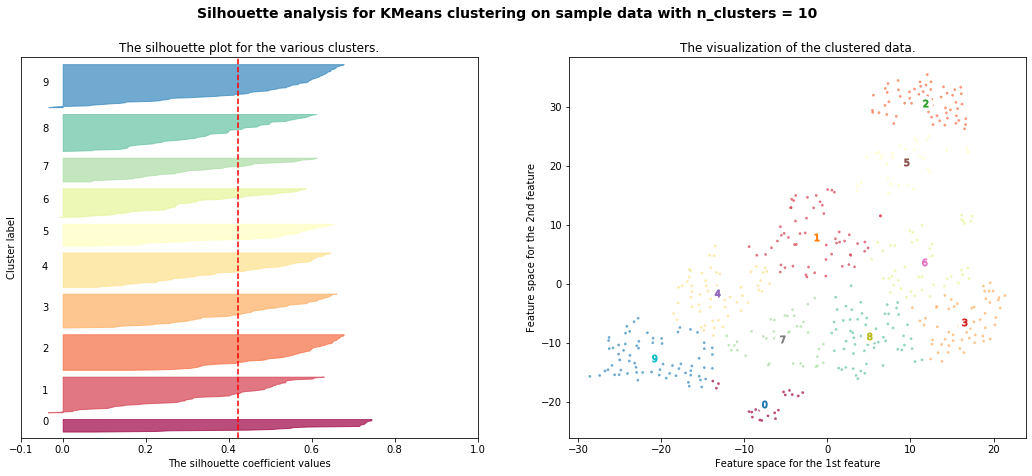

For n_clusters = 11 The average silhouette_score is : 0.41494536


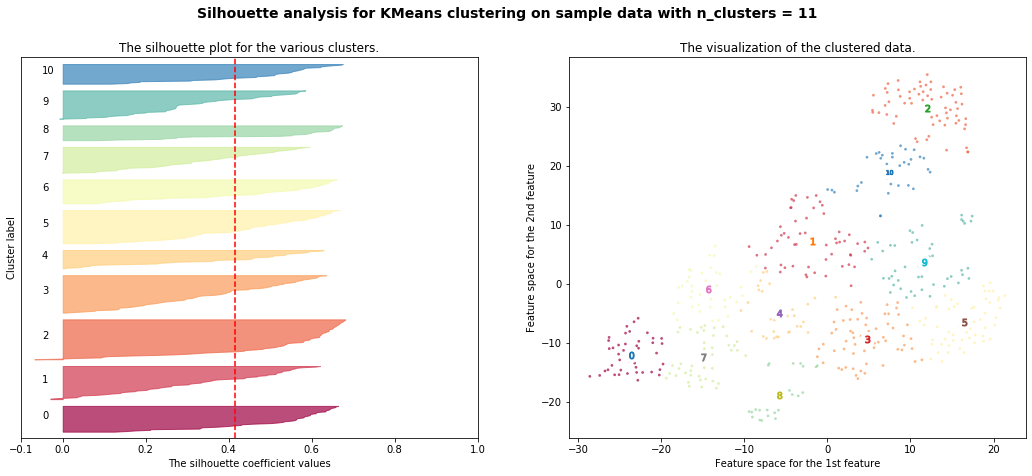

For n_clusters = 12 The average silhouette_score is : 0.41484487


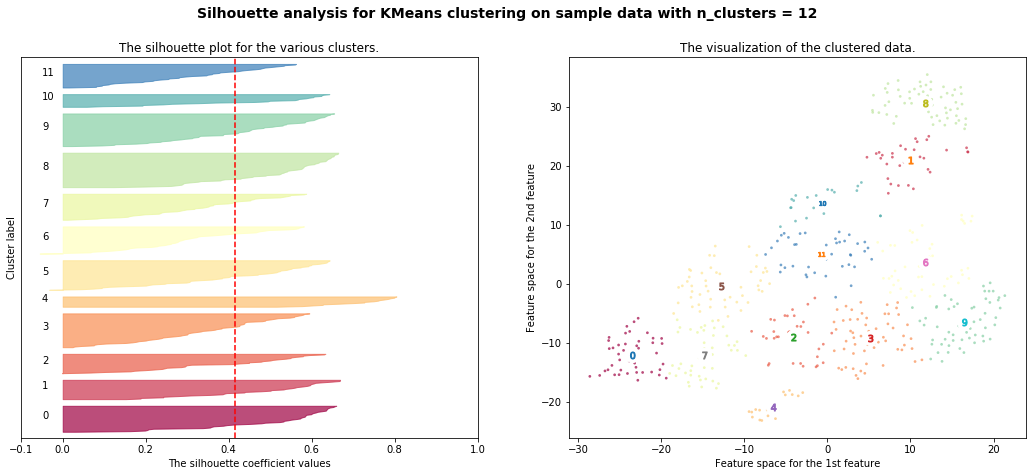

For n_clusters = 13 The average silhouette_score is : 0.40502813


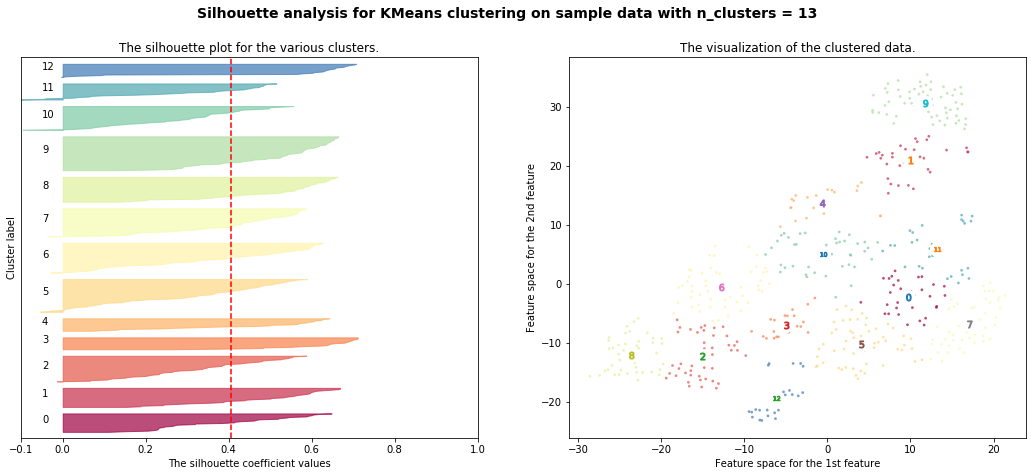

For n_clusters = 14 The average silhouette_score is : 0.415377


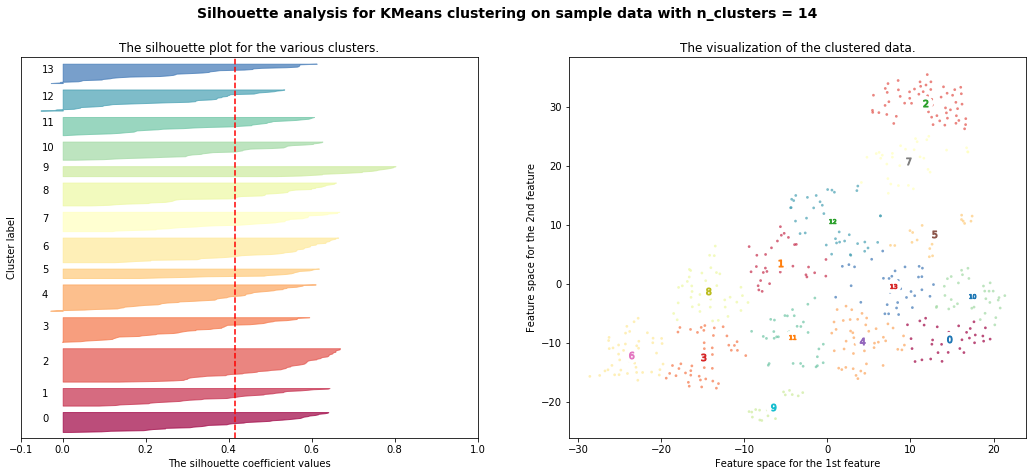

For n_clusters = 15 The average silhouette_score is : 0.4294765


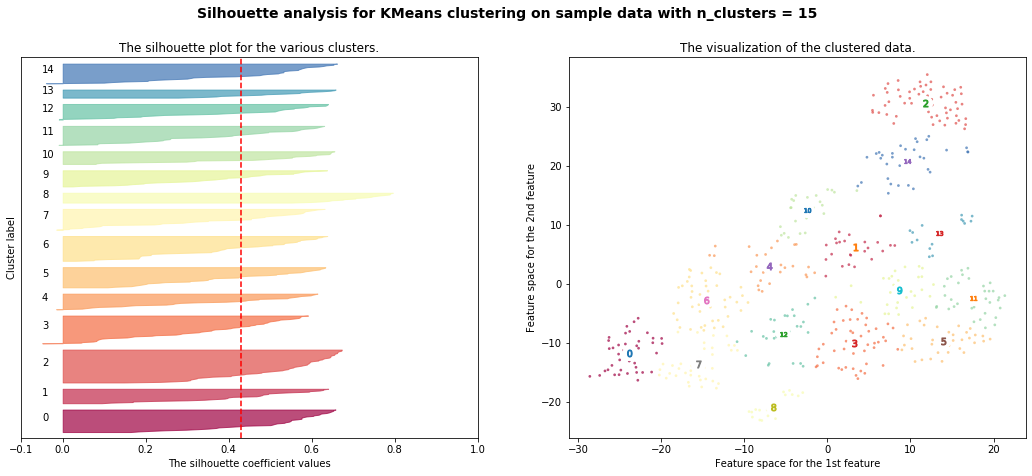

For n_clusters = 16 The average silhouette_score is : 0.41367894


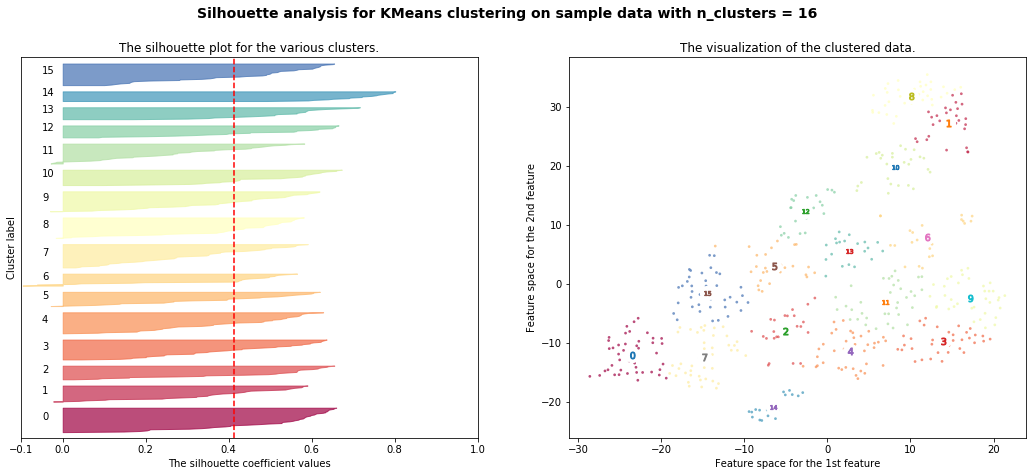

For n_clusters = 17 The average silhouette_score is : 0.4187981


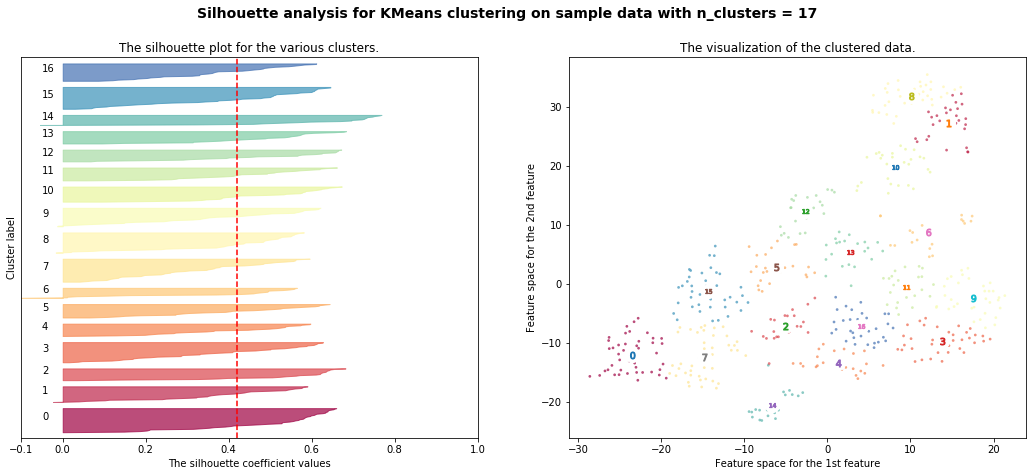

For n_clusters = 18 The average silhouette_score is : 0.4223531


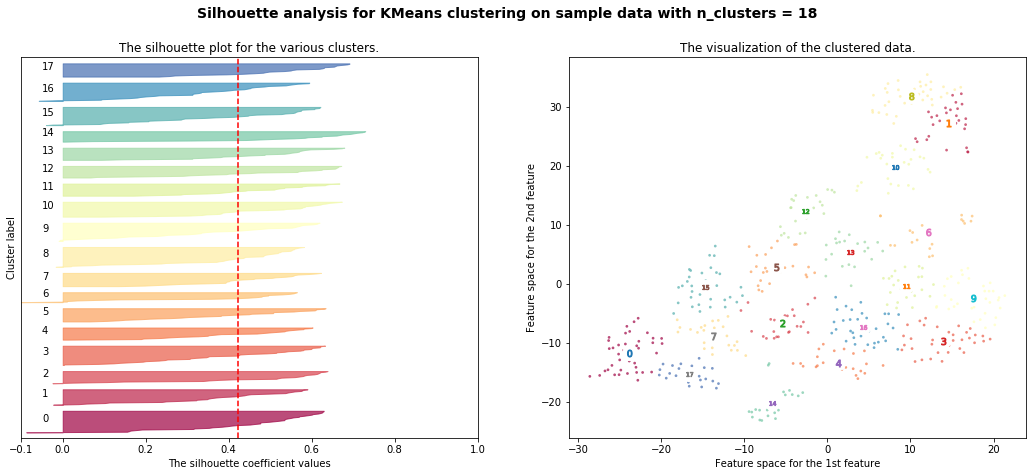

For n_clusters = 19 The average silhouette_score is : 0.42292652


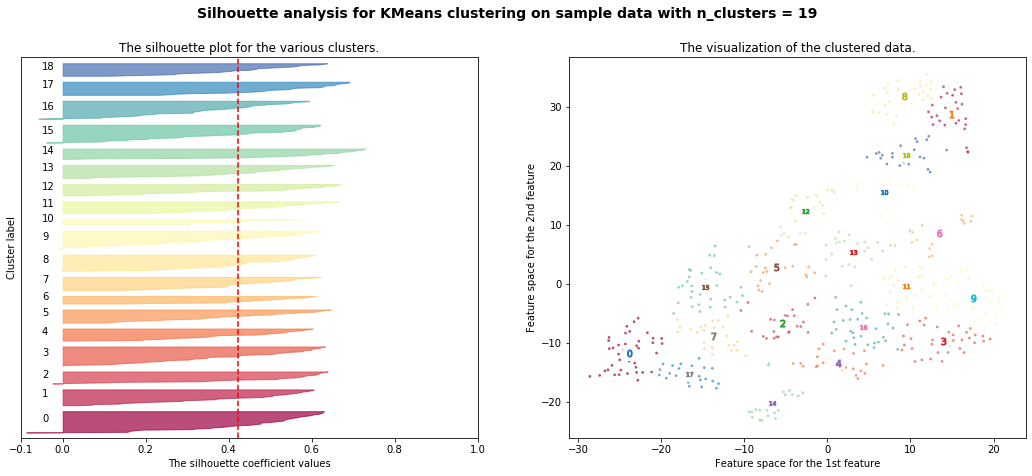

In [354]:
X = tsne
range_n_clusters = range(2,20)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed

    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## 3 Kmeans Clusters


In [355]:
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(X)

In [397]:
clusterer.cluster_centers_

array([[-14.153882 ,  -9.076331 ],
       [  9.459446 ,  24.08505  ],
       [  8.100563 ,  -3.2924562]], dtype=float32)

In [365]:
df_all_acc['kmeans_3'] = cluster_labels

In [423]:
df_all_acc['tsne_component1'] = tsne[:, 0]
df_all_acc['tsne_component2'] = tsne[:, 1]


Text(0.5, 1.0, 'Pitchers Accuracy by Cluster')

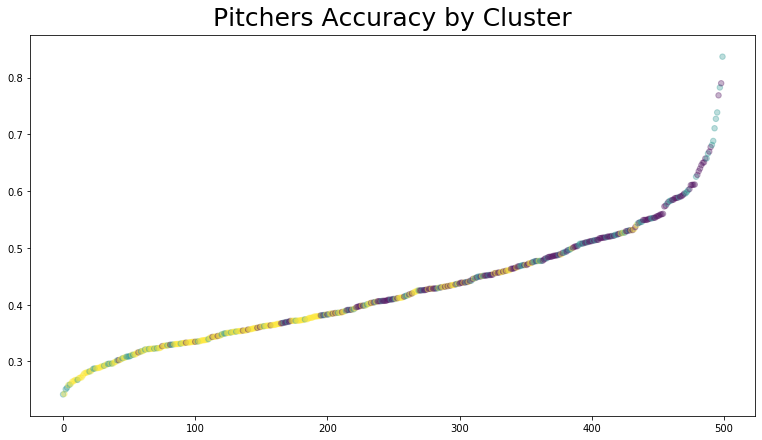

In [408]:
plt.figure(figsize=(13,7))
plt.scatter(df_all_acc.index, df_all_acc['accuracy'].values, c=df_all_acc['kmeans_3'].values, alpha=0.3, s=30)
plt.title('Pitchers Accuracy by Cluster', size=25, pad=10)

Text(0.5, 1.0, 'Number of Pitchers in each Cluster')

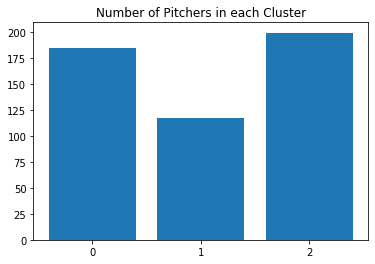

In [395]:
plt.bar(df_all_acc.groupby('kmeans_3').count().iloc[:, 0].index, df_all_acc.groupby('kmeans_3').count().iloc[:, 0].values)
plt.xticks([0,1,2])
plt.title('Number of Pitchers in each Cluster')


In [ ]:
plt.bar(df_all_acc.groupby('kmeans_3').count())

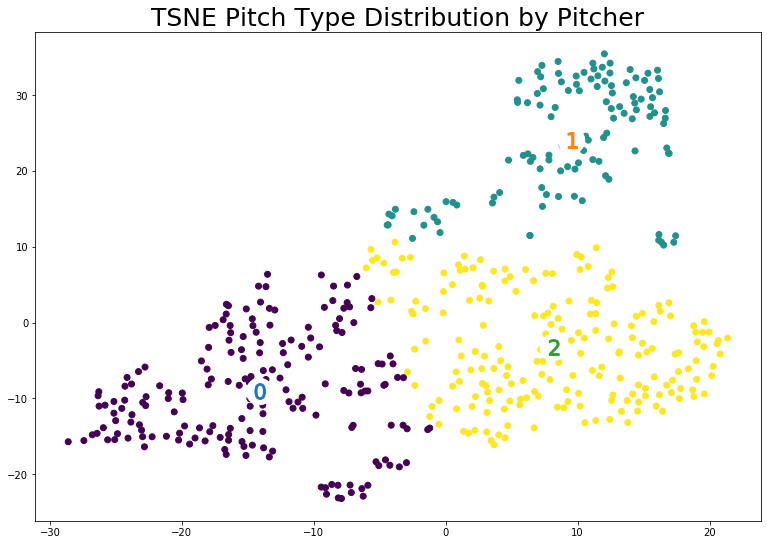

In [401]:
plt.figure(figsize=(13,9))
plt.scatter(tsne[:, 0], tsne[:, 1], c=cluster_labels)
plt.title('TSNE Pitch Type Distribution by Pitcher', size=25)

centers = clusterer.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=1, s=700)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=250)

In [426]:
df_all_acc.to_csv('../Models/final_tsne_cluster_pitchers.csv')

In [415]:
centers[0]

array([-14.153882,  -9.076331], dtype=float32)

In [422]:
(tsne - centers[0])


array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1,

## Try 15 clusters